In [46]:
import os
import json
import warnings
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from sklearn.gaussian_process.kernels import Matern
from GPy.mappings.constant import Constant
from GPy.kern import Matern52
from GPy.models import GPRegression
import GPy

from scipy.special import ndtr
from scipy.stats import norm

warnings.filterwarnings('ignore')
# plt.style.use('classic')
plt.style.use('seaborn-paper')
%matplotlib inline

In [68]:
# plotting styles

def nnsvm(rcParams, i=0):
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = 'Ubuntu'
    rcParams['font.monospace'] = 'Ubuntu Mono'
    rcParams['font.size'] = 12 + i
    rcParams['axes.labelsize'] = 12 + i
    rcParams['axes.labelweight'] = 'normal'
    rcParams['xtick.labelsize'] = 10 + i
    rcParams['ytick.labelsize'] = 10 + i
    rcParams['legend.fontsize'] = 12 + i
    rcParams['figure.titlesize'] = 14 + i
    rcParams['lines.linewidth']= 2.7
    rcParams['axes.titlesize'] = 14 + i
alpha_plt = 0.4 # beautification
    
# gifs stuff
gifDir = 'MAB_gifs'
os.makedirs(gifDir, exist_ok=True)
delay = 80

In [69]:
SPINE_COLOR = 'gray'

def format_axes(ax):
    
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)
        
#     ax.grid(alpha=0.25)

    return ax

In [70]:
def gp_creator(x, y, val = 5):
    y.resize(x.shape[0], 1)
    ker = Matern52(x.shape[1], ARD=True, variance=1)
#     print (x, x.mean())
    mean_fn = Constant(x.shape[1], 1, value=val)
    gp = GPRegression(x, y, kernel=ker, noise_var=0,
                      mean_function = mean_fn)
    gp.optimize()
    return gp

In [108]:
def f(x):
    """The function to predict."""
    return 2*((x-3)*np.sin((x-3))) + 2 + 0.5*x

nnsvm(plt.rcParams, -2)
x = np.atleast_2d(np.linspace(0, 6, 100000)).T
y_pred, sigma = 5*np.ones(x.shape).flatten(), 1.1*np.ones(x.shape).flatten()

train_X = np.array([[.3],[2.2], [3.7]])
train_y = f(train_X)

In [109]:
def plot_gray(n):
    y1 = mu-n*std
    y2 = mu+n*std
    y_temp = y_max_eps*np.ones_like(y1)
    plt.fill_between(
        x,y2,y1,where=y1>=y_temp,
        color='violet',alpha=alphas[n],
        interpolate=False, label=labels[n], linewidth=0
    )
    plt.fill_between(
        x,y2,y_temp,where=y2>=y_temp,
        color='violet',alpha=alphas[n],
        interpolate=False, linewidth=0
    )
    plt.fill_between(
        x,y2,y1,where=y2<=y_temp,
        color='black',alpha=alphas[n],
        interpolate=False, linewidth=0
    )
    plt.fill_between(
        x,y1,y_temp, where=y2>=y_temp,
        color='black',alpha=alphas[n],
        interpolate=False, linewidth=0
    )


In [110]:
nnsvm(plt.rcParams, 4)

In [111]:
class ACQ:
    def acq_fn(self, *args, **kwargs):
        raise NotImplemented
    def __str__(self):
        return self.__class__.__name__
    def __call__(self, *args, **kwargs):
        return self.acq_fn(*args, **kwargs)

In [112]:
# Code is heavily borrowed from: https://modal-python.readthedocs.io/
# en/latest/_modules/modAL/acquisition.html#max_PI
class PI(ACQ):
    def acq_fn(
        self, gp, x, mu=5., eps=0.01, **kwargs):
        """
        gp: sklearn.GPRegresssor
        """
        y_pred, var = [t.flatten() for t in gp.predict(x)]
        sigma = np.sqrt(var).squeeze()
        
        cdf = ndtr((y_pred - mu - eps)/sigma)
        return cdf

In [113]:
gp = gp_creator(train_X, train_y)
mu, var = gp.predict(x)
mu = mu.squeeze()
std = np.sqrt(var).squeeze()
# x = x.flatten()
# gp.plot(plot_density=True)

In [114]:
p = PI()
acq = p.acq_fn(gp, x, train_y.max().item(), eps=0.075)

x = x.flatten()

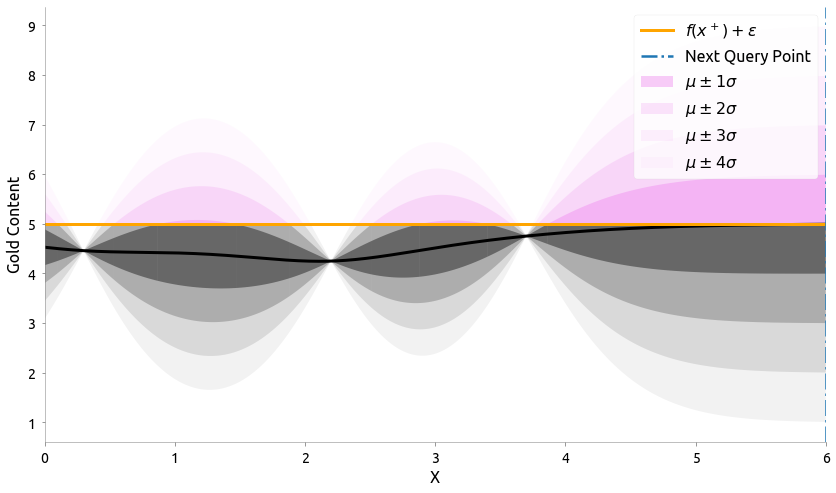

In [116]:
y_max_eps = mu.max()

plt.figure(figsize=(14, 8))
plt.plot(x, mu, color='k', lw=3)

alphas = {1:0.4, 2:0.2, 3:0.1, 4:0.05}
labels = {x:r'$\mu \pm %s\sigma$' %x for x in [1, 2, 3, 4]}

plt.axhline(y_max_eps, color='orange', lw=3, label=r'$f(x^+) + \epsilon$')
ix = np.argmax(acq)
plt.axvline(x[ix], linestyle="-.", lw=2.5, label = "Next Query Point")


plot_gray(1)
plot_gray(2)
plot_gray(3)
plot_gray(4)

plt.legend()
plt.xlabel("X")
plt.ylabel("Gold Content")
plt.xlim((x.min(), x.max()))
format_axes(plt.gca())
plt.savefig("MAB_gifs/density_pi.svg", bbox_inches="tight")